In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.2 MB/s eta 0:00:00


In [ ]:
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch] -U

In [ ]:
from datasets import list_datasets

In [ ]:
all_datasets=list_datasets()

<ipython-input-5-72a8cfa9b2f3>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets=list_datasets()


In [ ]:
from datasets import load_dataset

In [ ]:
emotions=load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = "distilbert-base-uncased"

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification


In [ ]:
num_labels = 6

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install torch -U

In [ ]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotio"
training_args = TrainingArguments(output_dir=model_name,
num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=logging_steps,
push_to_hub=True,
log_level="error")

In [ ]:
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.334535,0.904000,0.902794
2,No log,0.228270,0.921000,0.920898


TrainOutput(global_step=500, training_loss=0.5645923461914063, metrics={'train_runtime': 242.7734, 'train_samples_per_second': 131.81, 'train_steps_per_second': 2.06, 'total_flos': 720342861696000.0, 'train_loss': 0.5645923461914063, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])


In [ ]:
preds_output.metrics

{'test_loss': 0.22762468457221985,
 'test_accuracy': 0.918,
 'test_f1': 0.9176805775457905,
 'test_runtime': 3.7911,
 'test_samples_per_second': 527.551,
 'test_steps_per_second': 8.441}

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/Sarthak7777/distilbert-base-uncased-finetuned-emotio/tree/main/'

In [ ]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "sarthak7777/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = " I love you."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
labels = emotions["train"].features["label"].names

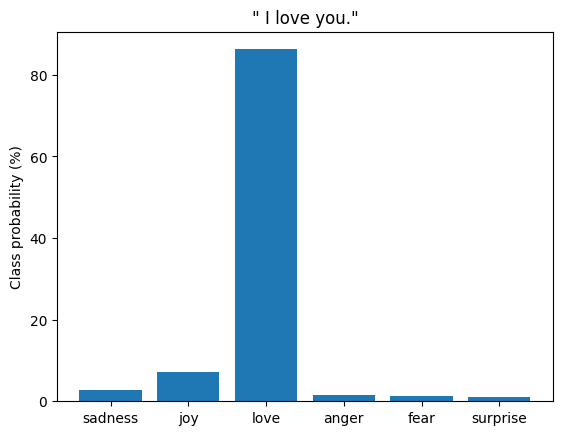

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()